# Exploration

- Looking for patterns

In [1229]:
# Preliminary setup
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1230]:
# Import dataset from alldata.pickle
df = pd.read_pickle("alldata.pickle")

In [1231]:
# Check datatypes
df.head(1)
df.dtypes

# Change object datatypes to float64 and '?' cells to NaN, since all are numerical columns
df['active'] = pd.to_numeric(df['active'], errors='coerce')
df['reactive'] = pd.to_numeric(df['reactive'], errors='coerce')
df['volts'] = pd.to_numeric(df['volts'], errors='coerce')
df['amps'] = pd.to_numeric(df['amps'], errors='coerce')
df['sub1'] = pd.to_numeric(df['sub1'], errors='coerce')
df['sub2'] = pd.to_numeric(df['sub2'], errors='coerce')

# Check that all numerical columns are float64
df.dtypes

,active,reactive,volts,amps,sub1,sub2,sub3
dtime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0


active       object
reactive     object
volts        object
amps         object
sub1         object
sub2         object
sub3        float64
dtype: object

active      float64
reactive    float64
volts       float64
amps        float64
sub1        float64
sub2        float64
sub3        float64
dtype: object

In [1232]:
# Simple stats
df.describe()

# Find time when sub1, sub2 and sub3 are max and min
print('Sub1 - Max:')
df['sub1'].idxmax()
print('Sub2 - Max:')
df['sub2'].idxmax()
print('Sub3 - Max:')
df['sub3'].idxmax()
print('\n\nSub1 - Min:')
df['sub1'].idxmin()
print('Sub2 - Min:')
df['sub2'].idxmin()
print('Sub3 - Min:')
df['sub3'].idxmin()

,active,reactive,volts,amps,sub1,sub2,sub3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


Sub1 - Max:


Timestamp('2010-02-21 14:09:00')

Sub2 - Max:


Timestamp('2010-02-07 14:57:00')

Sub3 - Max:


Timestamp('2008-05-06 23:18:00')



Sub1 - Min:


Timestamp('2006-12-16 17:24:00')

Sub2 - Min:


Timestamp('2006-12-16 17:39:00')

Sub3 - Min:


Timestamp('2006-12-16 22:16:00')

,active,reactive,volts,amps,sub1,sub2,sub3
dtime,,,,,,,
2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-28 17:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-22 22:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-22 22:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-25 17:52:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,0.98,'Timestamp of NULL rows:')

[Timedelta('0 days 00:01:00'),
 Timedelta('8 days 22:44:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('15 days 08:27:00'),
 Timedelta('13 days 22:37:00'),
 Timedelta('25 days 05:45:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('30 days 18:53:00'),
 Timedelta('33 days 06:29:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:01:00'),
 Ti

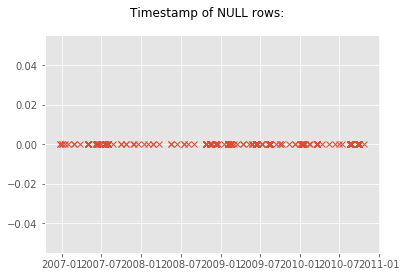

In [1233]:
# Deal with NaN cells

# Show rows with nulls
dfnulls = df[df.isnull().any(axis=1)]
dfnulls

# Looks like all columns are NaN, not just one at a time...
# Check the time positions of these
df1 = dfnulls.fillna(value=0)

plt.style.use('ggplot')

fig = plt.figure()
fig.suptitle('Timestamp of NULL rows:')
ax = plt.axes()
ts = df1['active']
ax.plot(ts, marker='x', linewidth=0)

# Check time periods between NaN rows
deltas = [d for d in map(lambda a: a[1] - a[0], zip(dfnulls.index, dfnulls.index[1:]))]
deltas

# Remove rows with NaN
df2 = df.dropna(how='any')

In [1234]:
# Look for outliers
# NOTE - there's either tons, or none.. so I think this means there aren't specific outliers to remove from the dataset?

for i in range(0, len(df.columns)-1):

    # calculate interquartile range
    q25, q75 = df.iloc[:,i].quantile(q=.25), df.iloc[:,i].quantile(q=.75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    outliers = [x for x in df['active'] if x < lower or x > upper]
    c = str(i+1)
    print('Column: ' + c)
    len(outliers)

Column: 1


94907

Column: 2


1211984

Column: 3


2049280

Column: 4


0

Column: 5


2049280

Column: 6


198603

In [1235]:
# Average over each hour
times = pd.to_datetime(df2.index)
df_houravg = df2.groupby([times.date, times.hour]).mean()

In [1236]:
# Choose a random 30-day period, for hourly averaged data
r = len(df_houravg.groupby(level=0).size())
n = np.random.randint(1,r)

date_array = np.unique(times.date)
date = date_array[n]
date_end = date_array[n+30]

# dates to strings for convenience in plotting titles
ds = date.strftime('%m/%d/%Y')
de = date_end.strftime('%m/%d/%Y')

Text(0.5,0.98,'Column: active from 04/03/2008 to 05/03/2008')

Text(0.5,0.98,'Column: reactive from 04/03/2008 to 05/03/2008')

Text(0.5,0.98,'Column: volts from 04/03/2008 to 05/03/2008')

Text(0.5,0.98,'Column: amps from 04/03/2008 to 05/03/2008')

Text(0.5,0.98,'Column: sub1 from 04/03/2008 to 05/03/2008')

Text(0.5,0.98,'Column: sub2 from 04/03/2008 to 05/03/2008')

Text(0.5,0.98,'Column: sub3 from 04/03/2008 to 05/03/2008')

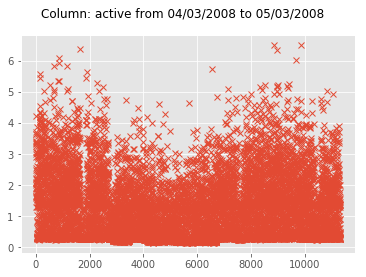

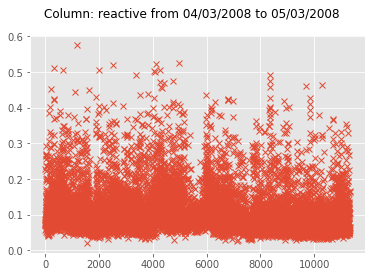

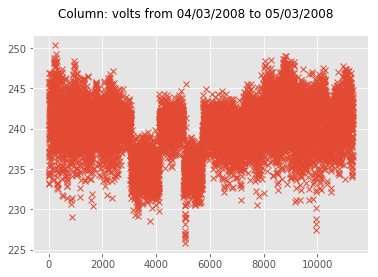

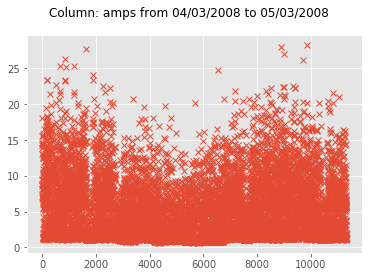

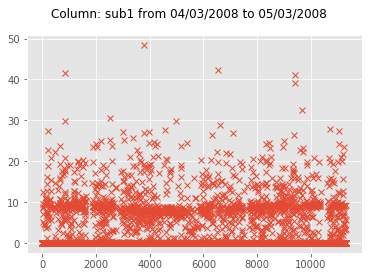

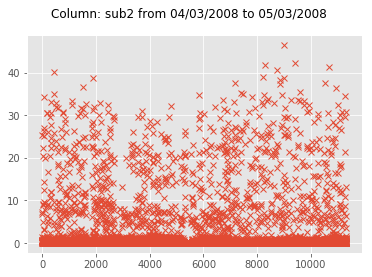

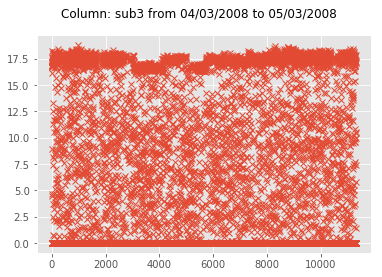

In [1237]:
# Plot each feature for a random month, averaged over each hour
plt.style.use('ggplot')

# take slice of 30day period
ts = df_houravg.loc(axis=0)[slice(date),:]
ts1 = ts.reset_index()
col_name = ts1.columns

# plot each feature
for i in range(2, len(ts1.columns)):

    col = col_name[i]
    title = 'Column: ' + col + ' from ' + ds + ' to ' + de
    ts2 = ts1.iloc[:,i]
    
    fig = plt.figure()
    fig.suptitle(title)
    ax = plt.axes()
    ax.plot(ts2, marker='x', linewidth=0)

In [1238]:
# Choose a random 30-day period for non averaged data
r = len(df2.index)
n = np.random.randint(1,r)
add = 60*24*30 #approx calculation of 1 month in minutes
end = n+add
date = df2.index[n]
date_end = df2.index[end]

# # dates to strings for convenience in plotting titles
ds = date.strftime('%m/%d/%Y')
de = date_end.strftime('%m/%d/%Y')

Text(0.5,0.98,'Lag 1 Plot: active from 09/25/2007 to 10/25/2007')

Text(0.5,0.98,'Lag 1 Plot: reactive from 09/25/2007 to 10/25/2007')

Text(0.5,0.98,'Lag 1 Plot: volts from 09/25/2007 to 10/25/2007')

Text(0.5,0.98,'Lag 1 Plot: amps from 09/25/2007 to 10/25/2007')

Text(0.5,0.98,'Lag 1 Plot: sub1 from 09/25/2007 to 10/25/2007')

Text(0.5,0.98,'Lag 1 Plot: sub2 from 09/25/2007 to 10/25/2007')

Text(0.5,0.98,'Lag 1 Plot: sub3 from 09/25/2007 to 10/25/2007')

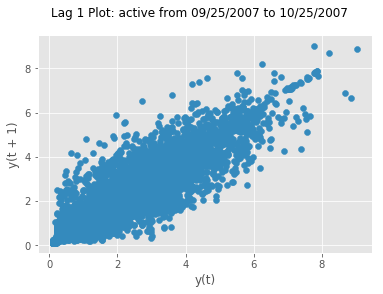

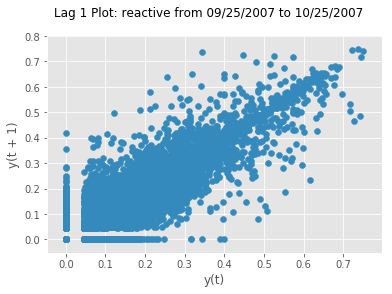

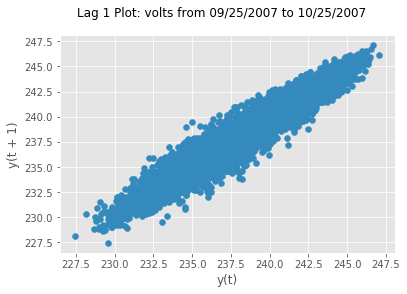

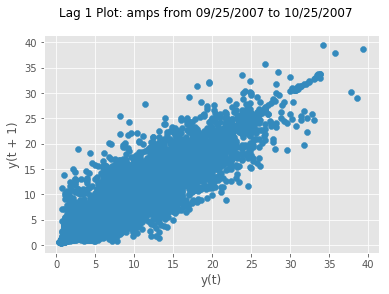

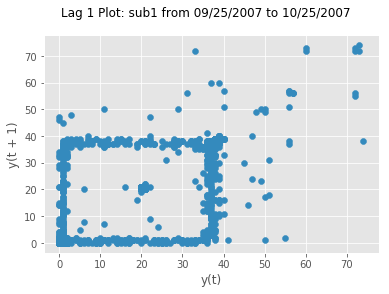

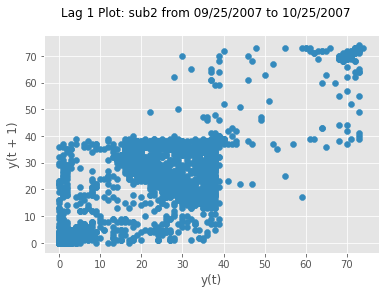

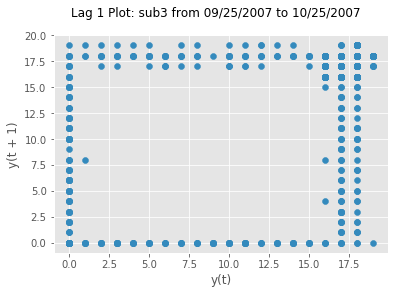

In [1239]:
# Look through Lag Plot for each column for patterns

# Set plot style
plt.style.use('ggplot')

# Look only at one month
mask = (df2.index > date) & (df2.index <= date_end)
ts = df.loc[mask]

col_name = ts.columns

# Lag plot for each column
for i in range(0, len(df.columns)):
    
    col = col_name[i]
    title = 'Lag 1 Plot: ' + col + ' from ' + ds + ' to ' + de
    x = ts.iloc[:,i] # set column

    fig = plt.figure()
    fig.suptitle(title)
    ax = plt.axes()
    lag_plot(x)

In [1240]:
# # Lag Lag Plots
# from mpl_toolkits.mplot3d import Axes3D

# x = df1.iloc[:,0]

# a = pd.DataFrame({'A' : numpy.array([1] * df1.shape[0],dtype='int32'),
#                  'B' : x,
#                  'C' : x.shift(1)})

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(a['A'], a['B'], a['C'])
# #fig.suptitle(title)